# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [606]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import pydotplus
from IPython.display import Image

In [607]:
# using SQLite Table to read data.
con = sqlite3.connect(os.path.join( os.getcwd(), '..', 'database.sqlite' )) 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [608]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [609]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [610]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [611]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [612]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [613]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [614]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [615]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [616]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [617]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [618]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [619]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [620]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [621]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [622]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [623]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [624]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [625]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [626]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [627]:
# Sampling the data 
final = final.sample(n=100000, replace=True)

In [628]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 100000/100000 [00:55<00:00, 1793.97it/s]


In [629]:
preprocessed_reviews[1500]

'much hotter normal green curry one pack makes many servings'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [630]:
## Similartly you can do preprocessing for review summary also.

In [631]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for summary in tqdm(final['Summary'].values):
    summary = re.sub(r"http\S+", "", summary)
    summary = BeautifulSoup(summary, 'lxml').get_text()
    summary = decontracted(summary)
    summary = re.sub("\S*\d\S*", "", summary).strip()
    summary = re.sub('[^A-Za-z]+', ' ', summary)
    # https://gist.github.com/sebleier/554280
    summary = ' '.join(e.lower() for e in summary.split() if e.lower() not in stopwords)
    
    preprocessed_summary.append(summary.strip())


100%|██████████| 100000/100000 [00:35<00:00, 2778.54it/s]


In [632]:
final['CleanedText'] = preprocessed_reviews #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText'] = final['CleanedText'].astype('str')

final['CleanedSummary'] = preprocessed_summary #adding a column of CleanedSummary which displays the data after pre-processing of the Summary 
final['CleanedSummary'] = final['CleanedSummary'].astype('str')

final['Text_Summary'] = final['CleanedSummary'] + final['CleanedText']

# # store final table into an SQlLite table for future.
# conn = sqlite3.connect('final.sqlite')
# c=conn.cursor()
# conn.text_factory = str
# final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
#              index=True, index_label=None, chunksize=None, dtype=None)
# conn.close()

# [4] Featurization

## [4.1] BAG OF WORDS

In [633]:
# #BoW
# count_vect = CountVectorizer() #in scikit-learn
# count_vect.fit(preprocessed_reviews)
# print("some feature names ", count_vect.get_feature_names()[:10])
# print('='*50)

# final_counts = count_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_counts))
# print("the shape of out text BOW vectorizer ",final_counts.get_shape())
# print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [634]:
# #bi-gram, tri-gram and n-gram

# #removing stop words like "not" should be avoided before building n-grams
# # count_vect = CountVectorizer(ngram_range=(1,2))
# # please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# # you can choose these numebrs min_df=10, max_features=5000, of your choice
# count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
# final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_bigram_counts))
# print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

## [4.3] TF-IDF

In [635]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
# tf_idf_vect.fit(preprocessed_reviews)
# print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
# print('='*50)

# final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
# print("the type of count vectorizer ",type(final_tf_idf))
# print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
# print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

## [4.4] Word2Vec

In [636]:
# # Train your own Word2Vec model using your own text corpus
# i=0
# list_of_sentance=[]
# for sentance in preprocessed_reviews:
#     list_of_sentance.append(sentance.split())

In [637]:
# # Using Google News Word2Vectors

# # in this project we are using a pretrained model by google
# # its 3.3G file, once you load this into your memory 
# # it occupies ~9Gb, so please do this step only if you have >12G of ram
# # we will provide a pickle file wich contains a dict , 
# # and it contains all our courpus words as keys and  model[word] as values
# # To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# # from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# # it's 1.9GB in size.


# # http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# # you can comment this whole cell
# # or change these varible according to your need

# is_your_ram_gt_16g=False
# want_to_use_google_w2v = False
# want_to_train_w2v = True

# if want_to_train_w2v:
#     # min_count = 5 considers only words that occured atleast 5 times
#     w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
#     print(w2v_model.wv.most_similar('great'))
#     print('='*50)
#     print(w2v_model.wv.most_similar('worst'))
    
# elif want_to_use_google_w2v and is_your_ram_gt_16g:
#     if os.path.isfile('GoogleNews-vectors-negative300.bin'):
#         w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
#         print(w2v_model.wv.most_similar('great'))
#         print(w2v_model.wv.most_similar('worst'))
#     else:
#         print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

In [638]:
# w2v_words = list(w2v_model.wv.vocab)
# print("number of words that occured minimum 5 times ",len(w2v_words))
# print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [639]:
# # average Word2Vec
# # compute average word2vec for each review.
# sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
# for sent in tqdm(list_of_sentance): # for each review/sentence
#     sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
#     cnt_words =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words:
#             vec = w2v_model.wv[word]
#             sent_vec += vec
#             cnt_words += 1
#     if cnt_words != 0:
#         sent_vec /= cnt_words
#     sent_vectors.append(sent_vec)
# print(len(sent_vectors))
# print(len(sent_vectors[0]))

#### [4.4.1.2] TFIDF weighted W2v

In [640]:
# # S = ["abc def pqr", "def def def abc", "pqr pqr def"]
# model = TfidfVectorizer()
# tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# # we are converting a dictionary with word as a key, and the idf as a value
# dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [641]:
# # TF-IDF weighted Word2Vec
# tfidf_feat = model.get_feature_names() # tfidf words/col-names
# # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
# row=0;
# for sent in tqdm(list_of_sentance): # for each review/sentence 
#     sent_vec = np.zeros(50) # as word vectors are of zero length
#     weight_sum =0; # num of words with a valid vector in the sentence/review
#     for word in sent: # for each word in a review/sentence
#         if word in w2v_words and word in tfidf_feat:
#             vec = w2v_model.wv[word]
# #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
#             # to reduce the computation we are 
#             # dictionary[word] = idf value of word in whole courpus
#             # sent.count(word) = tf valeus of word in this review
#             tf_idf = dictionary[word]*(sent.count(word)/len(sent))
#             sent_vec += (vec * tf_idf)
#             weight_sum += tf_idf
#     if weight_sum != 0:
#         sent_vec /= weight_sum
#     tfidf_sent_vectors.append(sent_vec)
#     row += 1

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

In [642]:
# Source: https://docs.python.org/3/library/pickle.html

# Saving data to pickle file
def topicklefile(obj, file_name):
    pickle.dump(obj,open(file_name+'.pkl', 'wb'))

In [643]:
# Data from pickle file
def frompicklefile(file_name):
    data = pickle.load(open(file_name+'.pkl', 'rb'))
    return data

In [644]:
# Sort 'Time' column
final = final.sort_values(by='Time', ascending=True)

In [645]:
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

# Train Test split for train and test data
def data_split(X,y):
    # split the data set into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=False)
    topicklefile(X_train, 'X_train')
    topicklefile(X_test, 'X_test')
    topicklefile(y_train, 'y_train')
    topicklefile(y_test, 'y_test')

In [646]:
def apply_avgw2v_train_test(X_train, X_test):
    
    # Training own Word2Vec model using your own text corpus
    list_of_sent_train = []
    for sent in X_train:#final['Text_Summary'].values:
        list_of_sent_train.append(sent.split())
    list_of_sent_test = []
    for sent in X_test:#final['Text_Summary'].values:
        list_of_sent_test.append(sent.split())

    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=8)

    w2v_words = list(w2v_model.wv.vocab)
#     print("number of words that occured minimum 5 times ",len(w2v_words))
#     print("sample words ", w2v_words[0:50])

    # compute average word2vec for each review for train data 
    avgw2v_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent_train): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        avgw2v_train.append(sent_vec)
#     print(len(avgw2v_train))
#     print(len(avgw2v_train[0]))

    # compute average word2vec for each review for test data 
    avgw2v_test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sent_test): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        avgw2v_test.append(sent_vec)
#     print(len(avgw2v_test))
#     print(len(avgw2v_test[0]))
    
    return avgw2v_train, avgw2v_test
    

In [647]:
def apply_tfidfw2v_train_test(X_train, X_test):
    
    # Training own Word2Vec model using your own text corpus
    list_of_sent_train = []
    for sent in X_train:#final['Text_Summary'].values:
        list_of_sent_train.append(sent.split())
    list_of_sent_test = []
    for sent in X_test:#final['Text_Summary'].values:
        list_of_sent_test.append(sent.split())
    
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sent_train,min_count=5,size=50, workers=16)

    w2v_words = list(w2v_model.wv.vocab)

    model = TfidfVectorizer()
    tf_idf_matrix = model.fit_transform(X_train)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidfw2v_train = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent_train): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidfw2v_train.append(sent_vec)
        row += 1

        
    tf_idf_matrix = model.transform(X_test)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

    # TF-IDF weighted Word2Vec
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidfw2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sent_test): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidfw2v_test.append(sent_vec)
        row += 1

        
    return tfidfw2v_train, tfidfw2v_test



In [648]:
# Applying BOW on train and test data and creating the 
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack


def apply_vectorizers_train_test(model_name, train_data, test_data):
    
    if model_name == 'BOW':
        #Applying BoW on Train data
        count_vect = CountVectorizer()
        
        #Applying BoW on Test data
        train_vect = count_vect.fit_transform(train_data)

        #Applying BoW on Test data similar to the bow_train data 
        test_vect = count_vect.transform(test_data)
        
        topicklefile(train_vect, 'train_vect')
        topicklefile(test_vect, 'test_vect')
        
        print("'train_vect' and 'test_vect' are the pickle files.")
        return count_vect
            
    elif model_name == 'TF-IDF':
        #Applying TF-IDF on Train data
        count_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
        
        #Applying BoW on Test data
        train_vect = count_vect.fit_transform(train_data)

        #Applying BoW on Test data similar to the bow_train data 
        test_vect = count_vect.transform(test_data)
        
        topicklefile(train_vect, 'train_vect')
        topicklefile(test_vect, 'test_vect')
        
        print("'train_vect' and 'test_vect' are the pickle files.")
        return count_vect
    
    elif model_name == 'AvgW2V':
        train_vect, test_vect = apply_avgw2v_train_test(train_data, test_data)
        
        topicklefile(train_vect, 'train_vect')
        topicklefile(test_vect, 'test_vect')
        print("'train_vect' and 'test_vect' are the pickle files.")
        
    elif model_name == 'TF-IDF W2V':
        train_vect, test_vect = apply_tfidfw2v_train_test(train_data, test_data)
        
        topicklefile(train_vect, 'train_vect')
        topicklefile(test_vect, 'test_vect')
        print("'train_vect' and 'test_vect' are the pickle files.")
        
    else:
        #Error Message
        print('Model specified is not valid! Please check.')

In [649]:
def applying_decision_tree(parameters, train_data, y_train):

    dt_clf = DecisionTreeClassifier(class_weight='balanced')
#     print(dt_clf)
    clf = GridSearchCV(dt_clf, parameters, cv=10, scoring= 'roc_auc', n_jobs=-1,return_train_score = True)
#     print(clf)
    clf.fit(train_data, y_train)
    
    clf_cv_results = pd.DataFrame(clf.cv_results_)
    
#     print(clf_cv_results)
    
    max_depth_optimal = clf.best_params_.get('max_depth')
    min_samples_split_optimal = clf.best_params_.get('min_samples_split')
    
#     train_auc= clf.cv_results_['mean_train_score']
#     train_auc_std= clf.cv_results_['std_train_score']
#     cv_auc = clf.cv_results_['mean_test_score'] 
#     cv_auc_std= clf.cv_results_['std_test_score']
    
    return clf_cv_results, max_depth_optimal, min_samples_split_optimal
    
#     return clf, train_auc, train_auc_std, cv_auc, cv_auc_std

In [650]:
#Source: https://stackoverflow.com/questions/48791709/how-to-plot-a-heat-map-on-pivot-table-after-grid-search
def train_cv_error_plot(cv_results, values_param):

    pvt = pd.pivot_table(cv_results, values=values_param, index='param_max_depth', columns='param_min_samples_split')
    sns.set(font_scale=1.4)
    ax = sns.heatmap(pvt, annot=True, cmap='mako_r', fmt='.2g')

In [651]:
def decision_tree_optimal(max_depth_optimal, min_samples_split_optimal,train_vec, y_train):
    dt_optimal = DecisionTreeClassifier(max_depth = max_depth_optimal, min_samples_split = min_samples_split_optimal, class_weight='balanced')
    
    # fitting the model with optimal K for training data
    dt_optimal.fit(train_vec, y_train)
    
    return dt_optimal

In [652]:
# Confusion Matrix
def cm_fig(dt_optimal, y_test, test_vec):
    cm = pd.DataFrame(confusion_matrix(y_test, dt_optimal.predict(test_vec)))
    # print(confusion_matrix(y_test, y_pred))
     
    plt.figure(1, figsize=(18,5))
    plt.subplot(121)
    plt.title("Confusion Matrix")
    sns.set(font_scale=1.4)
    sns.heatmap(cm, cmap= 'gist_earth', annot=True, annot_kws={'size':15}, fmt='g')

In [653]:
#Reference: https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci 
def error_plot(dt_optimal, train_vec, y_train, test_vec, y_test):
    train_fpr, train_tpr, thresholds = roc_curve(y_train, dt_optimal.predict_proba(train_vec)[:,1])
    test_fpr, test_tpr, thresholds = roc_curve(y_test, dt_optimal.predict_proba(test_vec)[:,1])

    plt.plot(train_fpr, train_tpr, label="train AUC = %0.3f" %auc(train_fpr, train_tpr))
    plt.plot(test_fpr, test_tpr, label="train AUC = %0.3f" %auc(test_fpr, test_tpr))
    plt.plot([0.0, 1.0], [0.0, 1.0],'k--')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.show()
    
    return auc(test_fpr, test_tpr)

In [703]:
#Source: https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
def get_features_top(count_vect, dt_optimal):
    features=count_vect.get_feature_names()
    feature_prob=dt_optimal.feature_importances_.ravel()
    df_feature_proba = pd.DataFrame({'features':features, 'probabilities':feature_prob})
    df_feature_proba = df_feature_proba.sort_values(by=['probabilities'],ascending=False)
#     print(df_feature_proba)
    return df_feature_proba[:21]

In [655]:
#source: https://stackoverflow.com/questions/41166340/decision-trees-with-sklearn-and-visualization
#https://scikit-learn.org/stable/modules/tree.html
# https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
def dt_graphviz(dt_optimal, count_vect, name):
    
    dot_data = export_graphviz(dt_optimal, max_depth=3, out_file=name+'.dot', feature_names=count_vect.get_feature_names(), class_names=dt_optimal.feature_importances_.ravel().astype('str'), filled=True, rounded=True, special_characters=True)  
    graph = graphviz.Source(dot_data)
    
    from subprocess import call
    call(['dot', '-Tpng', 'tree.dot', '-o', name+'.png', '-Gdpi=600'])
    # Display in jupyter notebook
    Image(filename = name+'.png')

## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

In [656]:
# Please write all the code with proper documentation

In [657]:
X = np.array(final['Text_Summary'])
y = np.array(final['Score'])
data_split(X,y)
X_train = frompicklefile('X_train')
X_test = frompicklefile('X_test')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')
count_vect = apply_vectorizers_train_test('BOW', X_train, X_test)

'train_vect' and 'test_vect' are the pickle files.


In [658]:
train_vect = frompicklefile('train_vect')
test_vect = frompicklefile('test_vect')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')

In [659]:
# `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])

tree_max_depth = [1, 5, 10, 50, 100, 500, 1000]
min_samples_split_val = [5, 10, 100, 500]

parameters = {'max_depth':tree_max_depth, 'min_samples_split':min_samples_split_val}

# clf, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_decision_tree(parameters, train_vect, y_train)

cv_results, bow_max_depth_optimal, bow_min_samples_split_optimal = applying_decision_tree(parameters, train_vect, y_train)

print('bow_max_depth_optimal, bow_min_samples_split_optimal :',bow_max_depth_optimal, bow_min_samples_split_optimal)

bow_max_depth_optimal, bow_min_samples_split_optimal : 10 500


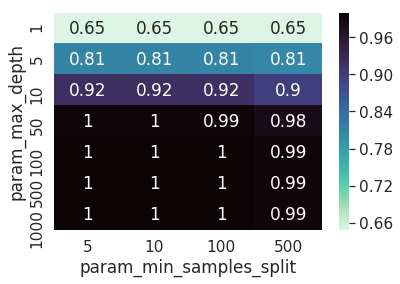

In [660]:
# print(cv_results[['mean_train_score','param_max_depth','param_min_samples_split']])
train_cv_error_plot(cv_results, 'mean_train_score')

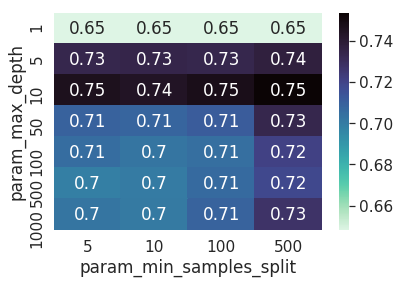

In [661]:
# print(cv_results[['mean_test_score','param_max_depth','param_min_samples_split']])
train_cv_error_plot(cv_results, 'mean_test_score')

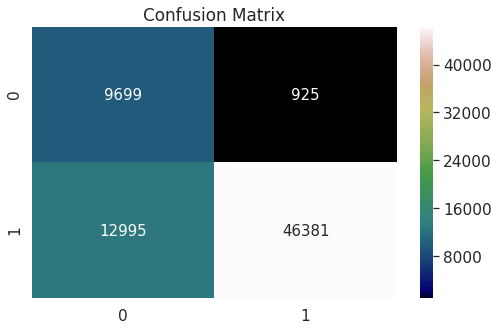

In [662]:
dt_optimal = decision_tree_optimal(bow_max_depth_optimal, bow_min_samples_split_optimal,train_vect, y_train)

cm_fig(dt_optimal, y_train, train_vect)

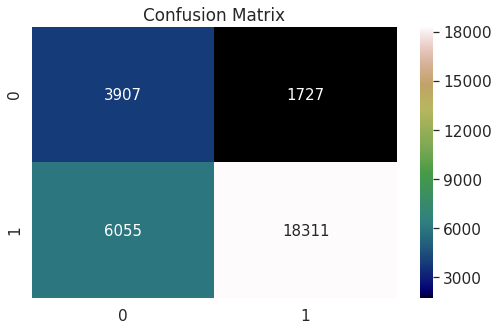

In [663]:
cm_fig(dt_optimal, y_test, test_vect)

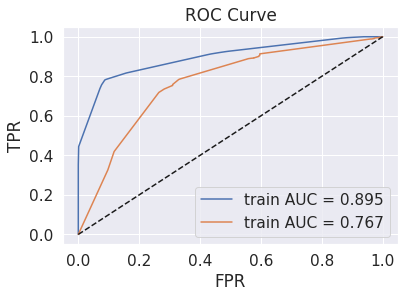

In [664]:
bow_auc1 = error_plot(dt_optimal, train_vect, y_train, test_vect, y_test)

### [5.1.1] Top 20 important features from<font color='red'> SET 1</font>

In [665]:
# Please write all the code with proper documentation

In [666]:
important_features = get_features_top(count_vect, dt_optimal)

important_features

,features,probabilities
8499,not,0.239564
5742,great,0.117021
817,bad,0.060600
3358,delicious,0.036199
754,away,0.033127
4487,excellent,0.027623
8457,no,0.021818
12601,taste,0.020623
8441,nice,0.020156
9194,perfect,0.019881


### [5.1.2] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

In [667]:
# Please write all the code with proper documentation

In [668]:
dt_graphviz(dt_optimal, count_vect, 'bow_tree')

## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

In [669]:
# Please write all the code with proper documentation

In [670]:
X = np.array(final['Text_Summary'])
y = np.array(final['Score'])
data_split(X,y)
X_train = frompicklefile('X_train')
X_test = frompicklefile('X_test')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')
count_vect = apply_vectorizers_train_test('TF-IDF', X_train, X_test)

'train_vect' and 'test_vect' are the pickle files.


In [671]:
train_vect = frompicklefile('train_vect')
test_vect = frompicklefile('test_vect')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')

In [672]:
# `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])

tree_max_depth = [1, 5, 10, 50, 100, 500, 1000]
min_samples_split_val = [5, 10, 100, 500]

parameters = {'max_depth':tree_max_depth, 'min_samples_split':min_samples_split_val}

# clf, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_decision_tree(parameters, train_vect, y_train)

cv_results, tfidf_max_depth_optimal, tfidf_min_samples_split_optimal = applying_decision_tree(parameters, train_vect, y_train)

print('tfidf_max_depth_optimal, tfidf_min_samples_split_optimal :',tfidf_max_depth_optimal, tfidf_min_samples_split_optimal)

tfidf_max_depth_optimal, tfidf_min_samples_split_optimal : 10 500


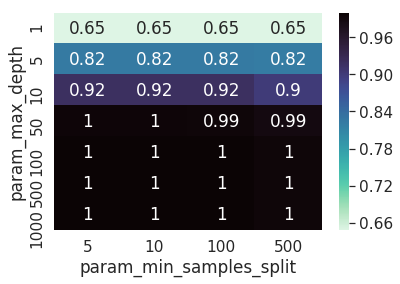

In [673]:
# print(cv_results[['mean_train_score','param_max_depth','param_min_samples_split']])
train_cv_error_plot(cv_results, 'mean_train_score')

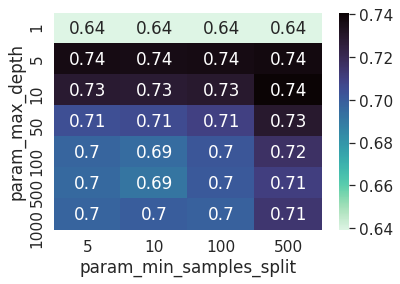

In [674]:
# print(cv_results[['mean_test_score','param_max_depth','param_min_samples_split']])
train_cv_error_plot(cv_results, 'mean_test_score')

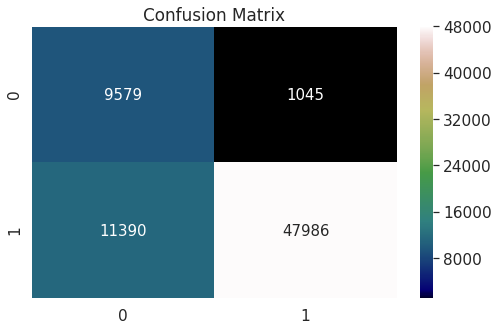

In [675]:
dt_optimal = decision_tree_optimal(tfidf_max_depth_optimal, tfidf_min_samples_split_optimal,train_vect, y_train)

cm_fig(dt_optimal, y_train, train_vect)

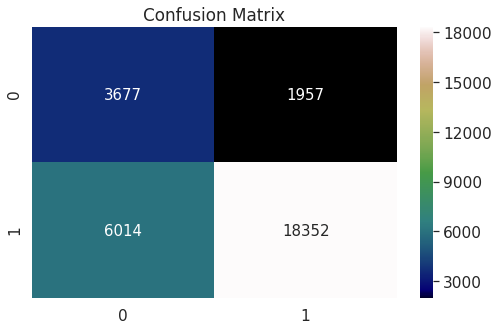

In [676]:
cm_fig(dt_optimal, y_test, test_vect)

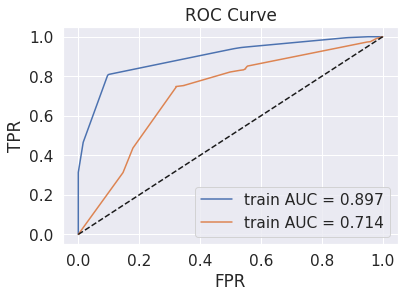

In [677]:
tfidf_auc1 = error_plot(dt_optimal, train_vect, y_train, test_vect, y_test)

### [5.2.1] Top 20 important features from<font color='red'> SET 2</font>

In [678]:
# Please write all the code with proper documentation

In [679]:
important_features = get_features_top(count_vect, dt_optimal)

important_features

,features,probabilities
67233,not,0.266822
45009,great,0.152697
25780,delicious,0.038032
43446,good,0.036255
6142,bad,0.034983
66276,nice,0.026859
74403,perfect,0.026490
66556,no,0.025885
5537,away,0.025321
58295,love,0.024264


### [5.2.2] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

In [680]:
# Please write all the code with proper documentation

In [681]:
dt_graphviz(dt_optimal, count_vect, 'tfidf_tree')

## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

In [682]:
# Please write all the code with proper documentation

In [683]:
X = np.array(final['Text_Summary'])
y = np.array(final['Score'])
data_split(X,y)
X_train = frompicklefile('X_train')
X_test = frompicklefile('X_test')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')
count_vect = apply_vectorizers_train_test('AvgW2V', X_train, X_test)

100%|██████████| 30000/30000 [01:40<00:00, 299.43it/s]


'train_vect' and 'test_vect' are the pickle files.


In [684]:
train_vect = frompicklefile('train_vect')
test_vect = frompicklefile('test_vect')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')

In [685]:
# `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])

tree_max_depth = [1, 5, 10, 50, 100, 500, 1000]
min_samples_split_val = [5, 10, 100, 500]

parameters = {'max_depth':tree_max_depth, 'min_samples_split':min_samples_split_val}

# clf, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_decision_tree(parameters, train_vect, y_train)

cv_results, avgw2v_max_depth_optimal, avgw2v_min_samples_split_optimal = applying_decision_tree(parameters, train_vect, y_train)

print('avgw2v_max_depth_optimal, avgw2v_min_samples_split_optimal :',avgw2v_max_depth_optimal, avgw2v_min_samples_split_optimal)

avgw2v_max_depth_optimal, avgw2v_min_samples_split_optimal : 5 10


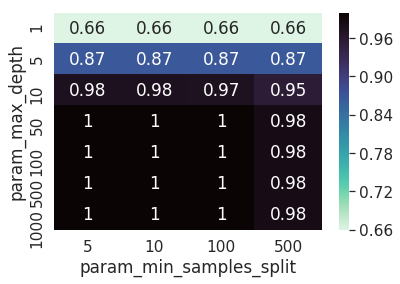

In [686]:
# print(cv_results[['mean_train_score','param_max_depth','param_min_samples_split']])
train_cv_error_plot(cv_results, 'mean_train_score')

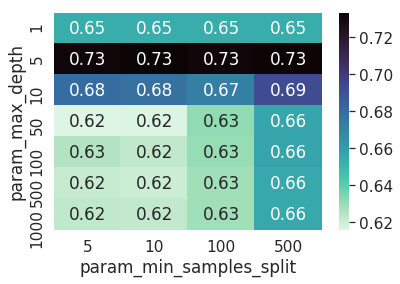

In [687]:
# print(cv_results[['mean_test_score','param_max_depth','param_min_samples_split']])
train_cv_error_plot(cv_results, 'mean_test_score')

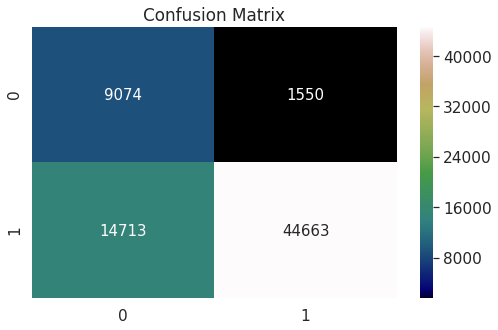

In [688]:
dt_optimal = decision_tree_optimal(avgw2v_max_depth_optimal, avgw2v_min_samples_split_optimal,train_vect, y_train)

cm_fig(dt_optimal, y_train, train_vect)

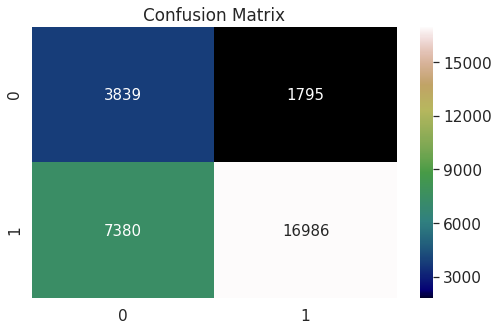

In [689]:
cm_fig(dt_optimal, y_test, test_vect)

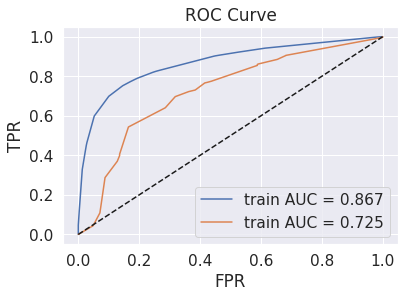

In [690]:
avgw2v_auc1 = error_plot(dt_optimal, train_vect, y_train, test_vect, y_test)

## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

In [691]:
# Please write all the code with proper documentation

In [692]:
X = np.array(final['Text_Summary'])
y = np.array(final['Score'])
data_split(X,y)
X_train = frompicklefile('X_train')
X_test = frompicklefile('X_test')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')
count_vect = apply_vectorizers_train_test('TF-IDF W2V', X_train, X_test)

100%|██████████| 30000/30000 [05:20<00:00, 93.53it/s] 


'train_vect' and 'test_vect' are the pickle files.


In [693]:
train_vect = frompicklefile('train_vect')
test_vect = frompicklefile('test_vect')
y_train = frompicklefile('y_train')
y_test = frompicklefile('y_test')

In [694]:
# `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])

tree_max_depth = [1, 5, 10, 50, 100, 500, 1000]
min_samples_split_val = [5, 10, 100, 500]

parameters = {'max_depth':tree_max_depth, 'min_samples_split':min_samples_split_val}

# clf, train_auc, train_auc_std, cv_auc, cv_auc_std = applying_decision_tree(parameters, train_vect, y_train)

cv_results, tfidfw2v_max_depth_optimal, tfidfw2v_min_samples_split_optimal = applying_decision_tree(parameters, train_vect, y_train)

print('tfidfw2v_max_depth_optimal, tfidfw2v_min_samples_split_optimal :',tfidfw2v_max_depth_optimal, tfidfw2v_min_samples_split_optimal)

tfidfw2v_max_depth_optimal, tfidfw2v_min_samples_split_optimal : 5 500


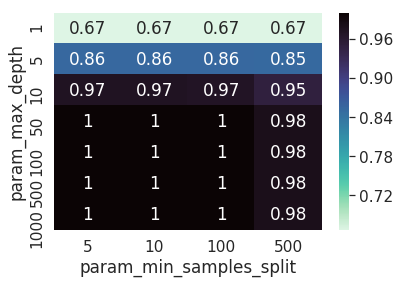

In [695]:
# print(cv_results[['mean_train_score','param_max_depth','param_min_samples_split']])
train_cv_error_plot(cv_results, 'mean_train_score')

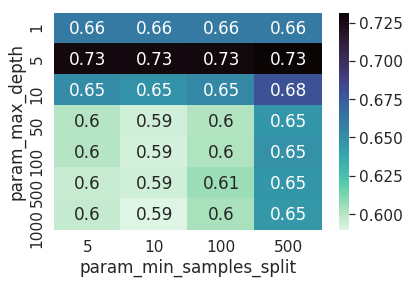

In [696]:
# print(cv_results[['mean_test_score','param_max_depth','param_min_samples_split']])
train_cv_error_plot(cv_results, 'mean_test_score')

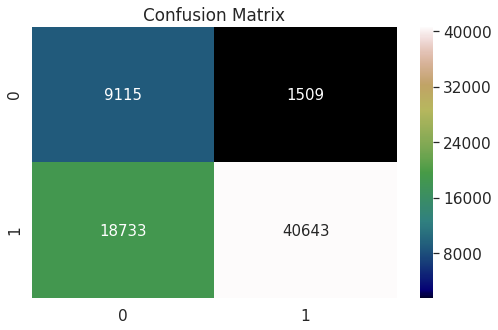

In [697]:
dt_optimal = decision_tree_optimal(tfidfw2v_max_depth_optimal, tfidfw2v_min_samples_split_optimal,train_vect, y_train)

cm_fig(dt_optimal, y_train, train_vect)

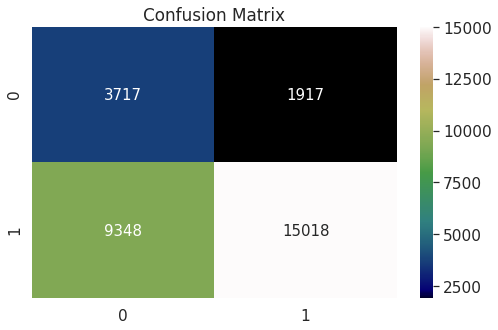

In [698]:
cm_fig(dt_optimal, y_test, test_vect)

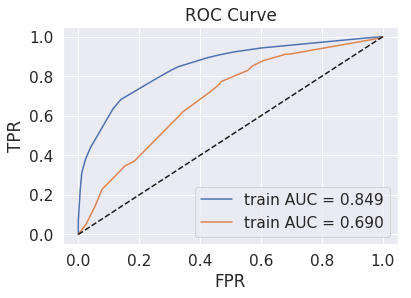

In [699]:
tfidfw2v_auc1 = error_plot(dt_optimal, train_vect, y_train, test_vect, y_test)

# [6] Conclusions

In [700]:
# Please compare all your models using Prettytable library

In [701]:
from prettytable import PrettyTable

model_metric = PrettyTable()

model_metric = PrettyTable(["Model Name", "Hyperparameter- Max Depth", 'Hyperparameter- Min Sample Split', 'AUC'])

model_metric.add_row(["Bag of Words",bow_max_depth_optimal, bow_min_samples_split_optimal, bow_auc1])
model_metric.add_row(["TF-IDF",tfidf_max_depth_optimal, tfidf_min_samples_split_optimal, tfidf_auc1])
model_metric.add_row(["Avg W2V",avgw2v_max_depth_optimal, avgw2v_min_samples_split_optimal, avgw2v_auc1])
model_metric.add_row(["TF-IDF W2V",tfidfw2v_max_depth_optimal, tfidfw2v_min_samples_split_optimal, tfidfw2v_auc1])

print(model_metric.get_string(start=0, end=8))

+--------------+---------------------------+----------------------------------+--------------------+
|  Model Name  | Hyperparameter- Max Depth | Hyperparameter- Min Sample Split |        AUC         |
+--------------+---------------------------+----------------------------------+--------------------+
| Bag of Words |             10            |               500                | 0.7666139167891989 |
|    TF-IDF    |             10            |               500                | 0.7142486893242739 |
|   Avg W2V    |             5             |                10                | 0.7248061569117346 |
|  TF-IDF W2V  |             5             |               500                | 0.6895136559492355 |
+--------------+---------------------------+----------------------------------+--------------------+


## [6.1] Observations

1) Training time: It is slightly lower to train the model for all the different type of vectorizers

2) Train and CV AUC score vs Hyperparameters representaion: Decision Tress have 2 hyperparameters(Max Depth and Min Sample Split) and the results are represented in Heatmaps for all the models. The best hyperparameter from GridsearchCV is with the highest AUC value for a set of both parameters.

3) Confusion Matrix: Confusion Matrix for both Train and Test set are plotted and they look consistent for a given model

4) ROC Curve: Performance of the models obtained on the Test data are slightly less than the Train data for all the models.

5) Tree Diagram: Tree diagram is obtained for BOW and TF-IDF based models. There are 2 files 'bow_tree.png' and 'tfidf_tree.png'